# Exploratory Data Analysis (EDA)

We need to get to know more about our training dataset. We will only use training dataset (not including val or test set) to prevent data leakage from happening (getting insight from future data while it is prohibited and not possible in real case). 

In [ ]:
import sys
sys.path.append('..') 

In [ ]:
## boilerplate
import src.util as utils

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import skew, kurtosis

In [ ]:
os.chdir(os.path.dirname(os.getcwd()))

In [ ]:
config = utils.load_config()

### Data Loading

In [ ]:
X_train = utils.pickle_load(config['train_set_path'][0])
y_train = utils.pickle_load(config['train_set_path'][1])
train_set = pd.concat([X_train, y_train], axis=1)

### Distribution Analysis
We will check the distribution of each sensors value by plotting a KDE Density Plot. With this, we can examine the distribution of sensor values and identify patterns, such as skewness, kurtosis, or multimodality.

Given the visualizations, the data doesn't have a bell-shaped curve, and have multiple peaks, and it seems that the features may have more complex distributions than initially suggested by the skewness and kurtosis values.

Thus, we will use ML algorithms that are capable of handling complex patterns and non-linear relationships between features, such as **decision trees**, **random forests**, **kNN** or neural networks.

In [ ]:
train_set_skewness = X_train.apply(skew)
train_set_kurtosis = X_train.apply(kurtosis)

print("Skewness:\n", train_set_skewness)
print("kurtosis:\n", train_set_kurtosis)

Skewness:
 MQ2     -0.381879
MQ3     -0.312261
MQ5      0.286472
MQ6      0.613343
MQ7     -0.630135
MQ8     -0.669563
MQ135   -0.327456
dtype: float64
kurtosis:
 MQ2     -1.216425
MQ3     -1.540658
MQ5     -0.443204
MQ6     -0.357825
MQ7     -0.235469
MQ8     -0.631198
MQ135   -0.879710
dtype: float64


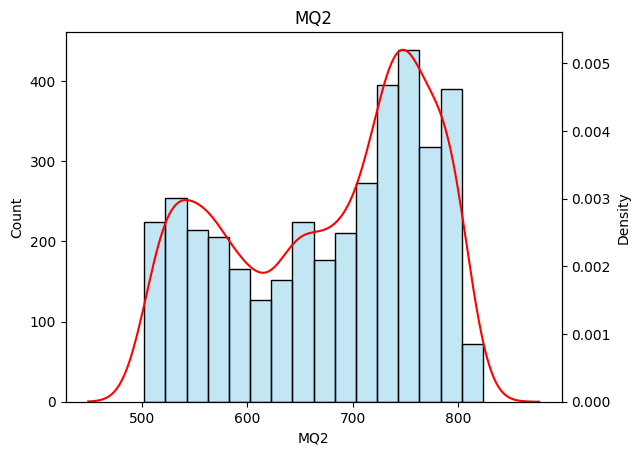

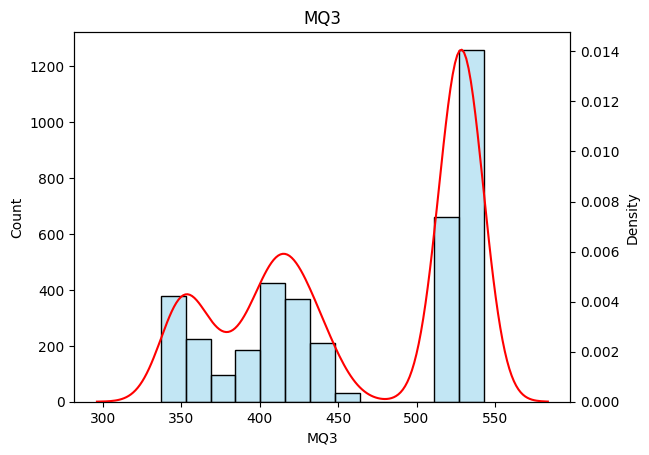

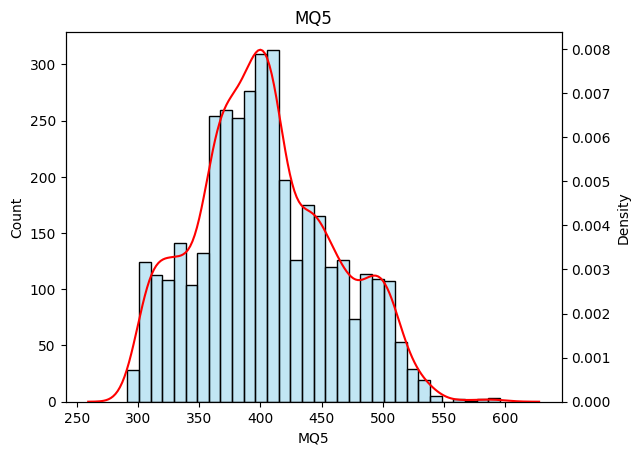

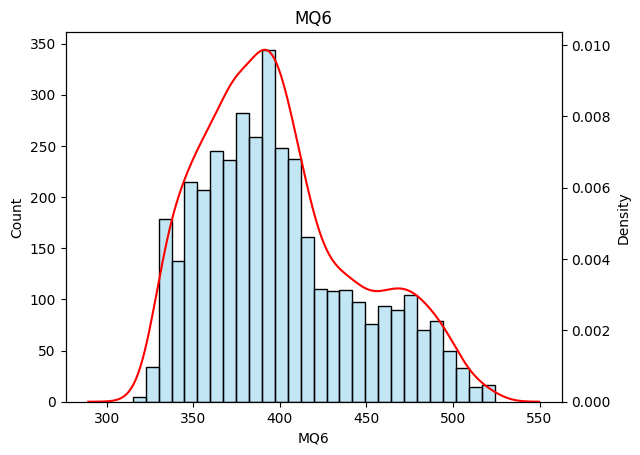

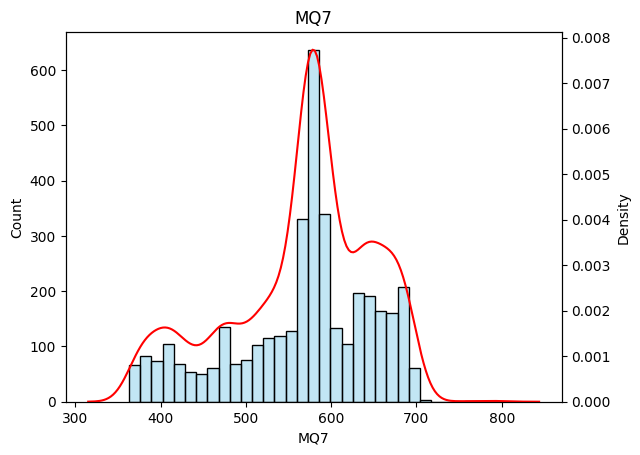

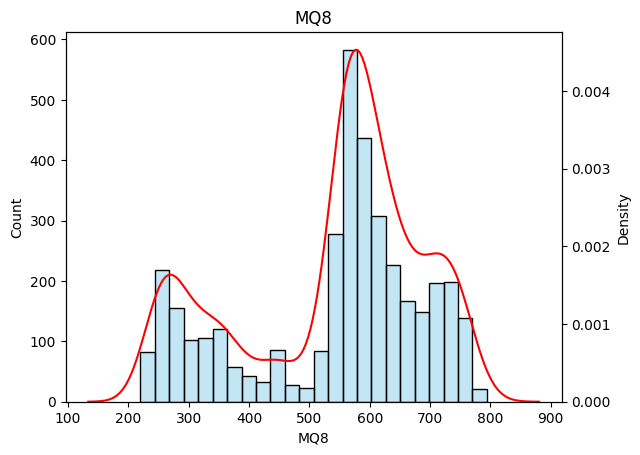

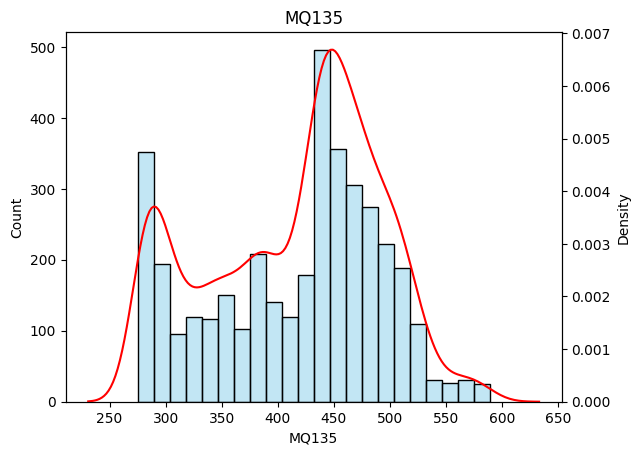

In [ ]:
for column in train_set.filter(regex='MQ.*').columns:
    fig, ax1 = plt.subplots()

    # Generate histogram
    sns.histplot(train_set[column], ax=ax1, color='skyblue', alpha=0.5)
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')

    # Add second y-axis for KDE plot
    ax2 = ax1.twinx()
    sns.kdeplot(train_set[column], ax=ax2, color='red')
    ax2.set_ylabel('Density')

    # other option, use this:
    # sns.histplot(train_set[column], kde=True)
    
    # Add title and show plot
    plt.title(column)
    plt.show()

### Outlier Check
With a box-plot, we can check the existance of outlier in each features (sensors).

Based on this information, we can see that some outlier does exist in feature (sensors) MQ5, MQ6, MQ7

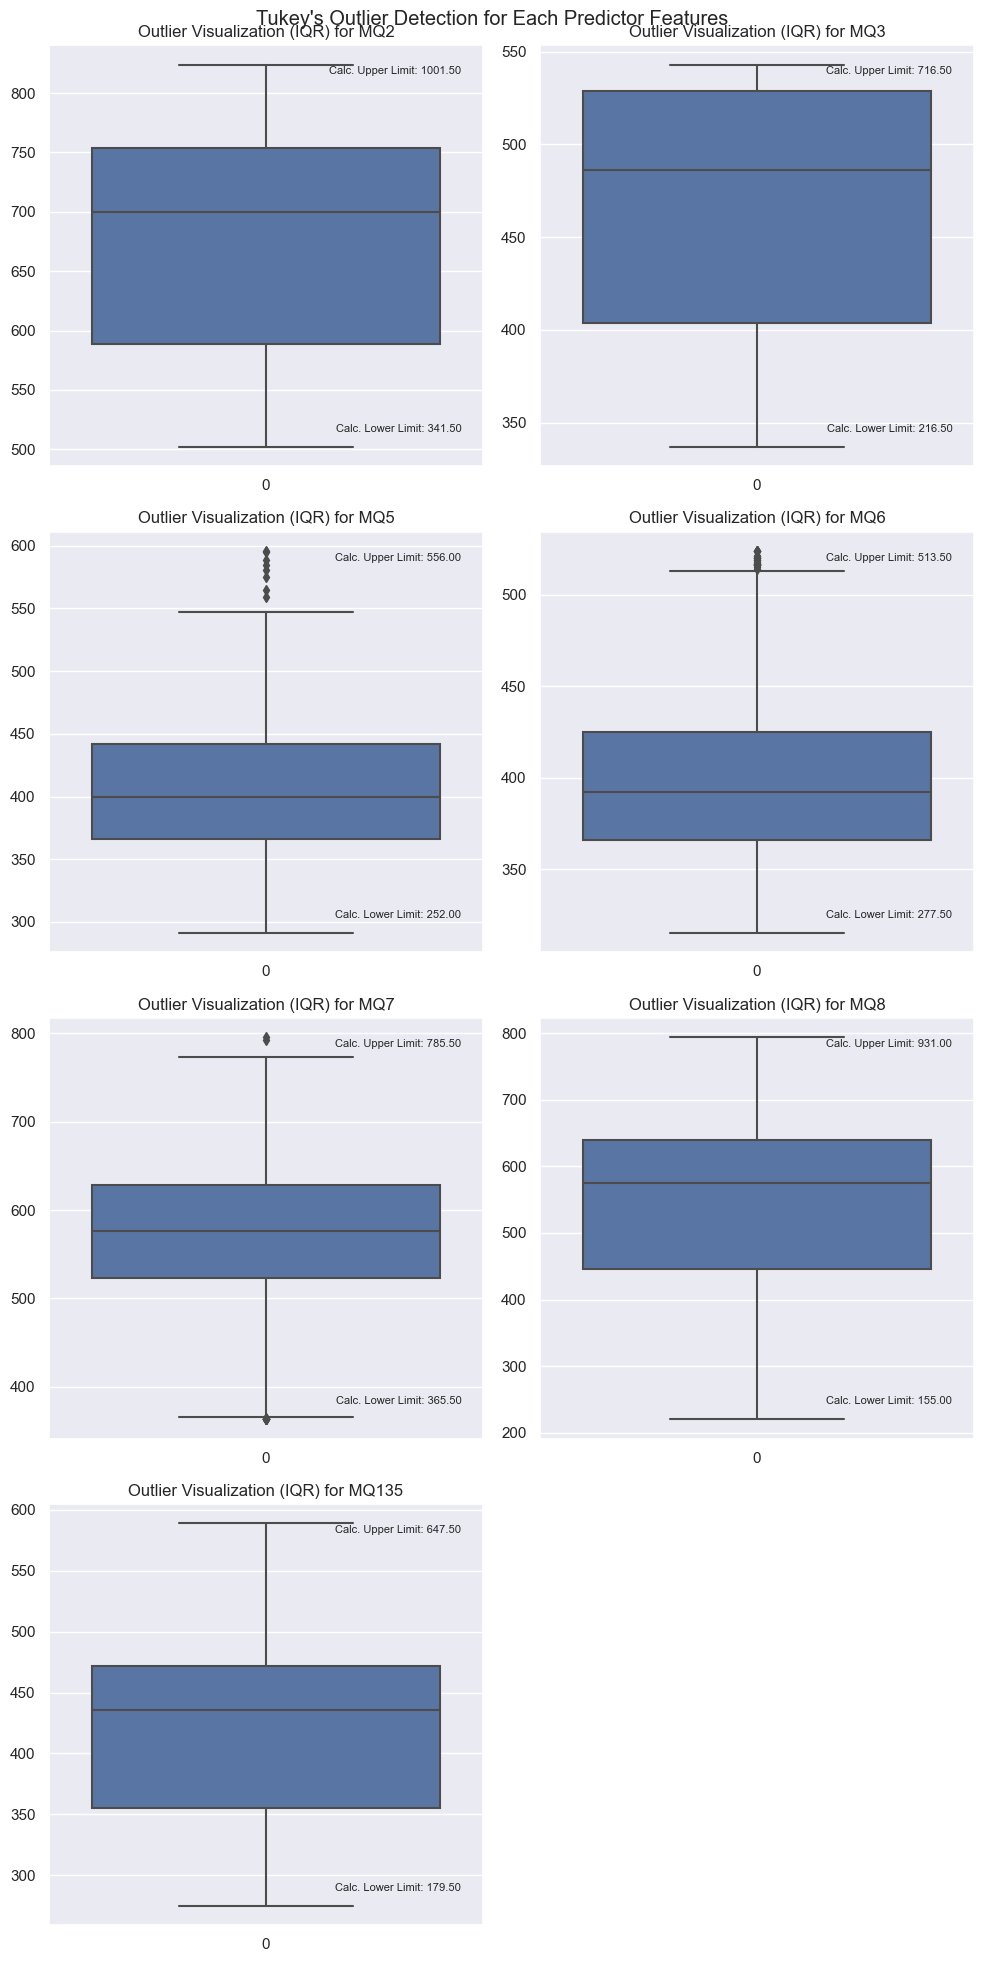

In [ ]:
sns.set_theme()
fig = plt.figure(figsize=(10, 20))
fig.suptitle('Tukey\'s Outlier Detection for Each Predictor Features')

for i, column in enumerate(config['predictors']):
    ax = plt.subplot(4, 2, i+1)
    q1 = train_set[column].quantile(0.25)
    q3 = train_set[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    sns.boxplot(train_set[column], whis=1.5, ax=ax)
    ax.text(0.95, 0.95, f'Calc. Upper Limit: {upper_bound:.2f}', transform=ax.transAxes, ha='right', va='top', fontsize=8)
    ax.text(0.95, 0.1, f'Calc. Lower Limit: {lower_bound:.2f}', transform=ax.transAxes, ha='right', va='top', fontsize=8)
    ax.set_title(f'Outlier Visualization (IQR) for {column}')

plt.tight_layout()
plt.show()

### Statistical Data Analysis
We can check the data types of each features, their length (count), null checking, value range and standard deviation.

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3840 entries, 160 to 2874
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MQ2     3840 non-null   int64 
 1   MQ3     3840 non-null   int64 
 2   MQ5     3840 non-null   int64 
 3   MQ6     3840 non-null   int64 
 4   MQ7     3840 non-null   int64 
 5   MQ8     3840 non-null   int64 
 6   MQ135   3840 non-null   int64 
 7   Gas     3840 non-null   object
dtypes: int64(7), object(1)
memory usage: 399.0+ KB


In [ ]:
train_set.isnull().sum()

MQ2      0
MQ3      0
MQ5      0
MQ6      0
MQ7      0
MQ8      0
MQ135    0
Gas      0
dtype: int64

In [ ]:
train_set.describe()

,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135
count,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000
mean,676.488802,461.673698,403.920573,399.175781,565.767187,541.181250,415.855208
std,92.668151,70.678710,55.569848,44.744833,83.097967,150.548237,76.479298
min,502.000000,337.000000,291.000000,315.000000,363.000000,220.000000,275.000000
25%,589.000000,404.000000,366.000000,366.000000,523.000000,446.000000,355.000000
50%,700.000000,486.000000,400.000000,392.000000,576.000000,575.000000,436.000000
75%,754.000000,529.000000,442.000000,425.000000,628.000000,640.000000,472.000000
max,824.000000,543.000000,596.000000,524.000000,796.000000,794.000000,589.000000


### Imbalanced Target Classes Check
Checking the class distribution to identify class imbalances.

Since the data has balanced classes (shown below), we don't need any sampling method to be applied later.

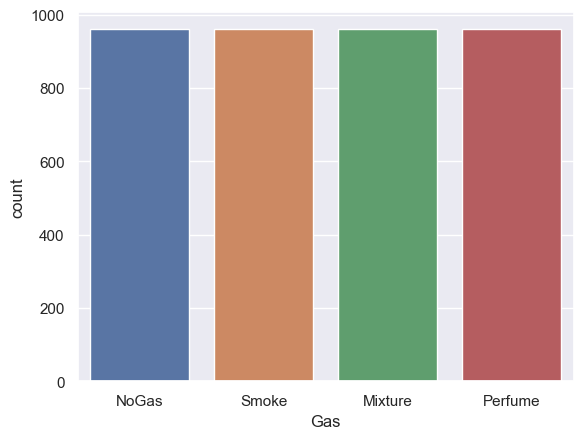

In [ ]:
sns.countplot(train_set, x="Gas")
plt.show()

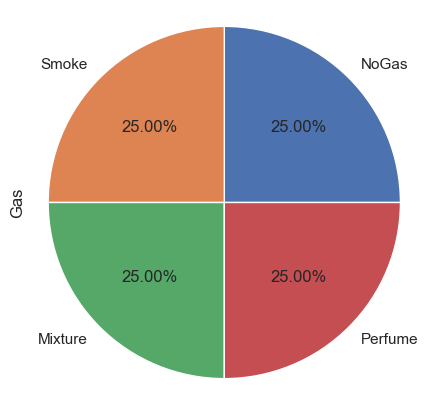

In [ ]:
plt.figure(figsize=(5,5))
train_set['Gas'].value_counts().plot(kind='pie', autopct='%.2f%%')
plt.axis('equal')
plt.show()

# Features Correlation Analysis
We will analyze the relationships between sensor values to identify highly correlated features. We may need this information if we observe any signs of overfitting.

C:\Users\HardoTriwahyu\AppData\Local\Temp\ipykernel_28872\3724191854.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_set.corr()


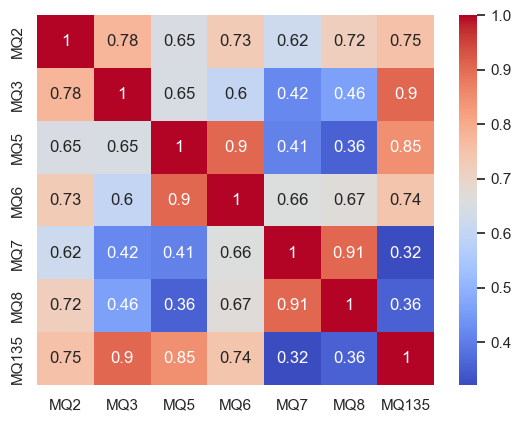

In [ ]:
corr_matrix = train_set.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

Highly correlated sensor with its possible reason:
- MQ7 (CO) and MQ8 (H2): the presence of CO might affect the sensor's ability to detect H2 or vice versa.
- MQ5 (LPG, Natural Gas) and MQ6 (LPG, Butane): due both sensor has a similar gas sensitivity

Beside that, highly correlated sensors could be the effect of **Overlapping sensitivites** or **Common Environmental** (responding to common environmental factors like temperature, humidity, or air pressure,)

### Feature Importance Check
Using mutual information method, we will check the feature importance of each sensors on the gas type.

It is shown below that the 3 most important features (sensors) are MQ3, MQ135, and MQ8. However, since our dataset is not large and the number of features is not excessively high, we may not need to perform feature selection unless overfitting is observed during model training.

In [19]:
X = train_set.loc[:, config['predictors']]
y = train_set.loc[:, config['obj_columns'][0]]
# Calculate the mutual information scores
mutual_info_scores = mutual_info_classif(X, y)

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame(mutual_info_scores, index=X.columns, columns=['mutual_info'])
feature_importance = feature_importance.sort_values(by='mutual_info', ascending=False)

# Display the feature importance scores
plt.bar(feature_importance['Features'], feature_importance['Mutual Info'])

# Add labels and titlea
plt.xlabel('Features')
plt.ylabel('Mutual Info')
plt.title('Mutual Info for each Feature')


,mutual_info
MQ3,0.792674
MQ135,0.640888
MQ8,0.561163
MQ7,0.436867
MQ5,0.414084
MQ2,0.350294
MQ6,0.339065
